# Vignette on Anomaly Detection

by Ivan Li, Justin Lang, Keon Dibley, Sanchit Mehtora

## Introduction

Anomaly detection is a powerful way to separate normal data from outliers. Additionally, it can help data scientists find those specific anomalies and inquire more about them: if they are errors in data collection or concerning values that require more attention. In this vignette, we will delve into different ways to find the anomaly values with data sets concerning climate and data network.



# Climate Data Analysis

## Dataset Description

The dataset that we used for climate data time series analysis came from kaggle at this [link]{https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data?resource=download}

It measured daily climate data in Delhi from 2013 to 2017 in the form of
 - mean temperature,
 - humidity,
 - speed
 - mean pressure



##  Methods

In the climate time series, we utilized sckit-learn's isolation forest in order to determine anomaly detection.

Isolation Forest in particular has four important hyperparameters that can be assigned.

    - n_estimators
        - # of trees in the Forest
    - max_samples
        - Samples per tree to train
    - contamination
        - How much of population do you think are anomalies
    - max_features
        - How many features used to train each tree


##  How Islation Forest Works

Anomalies exist because their feature values differ greatly from other regular values in the dataset. How an isolation forest works is that it creates trees and splits them randomly on thresholds. However, because the anomalies values differ so greatly, they are usually the first ones that branch off.

Isolation forest takes this into mind by using path length. The path length of a given value in a tree is how far the value is to the root or how many splits it takes to reach the value from the root. A shorter path length means a higher likelihood that the data is an anomaly. The algorithm of isolation forest decides that a value is an anomaly based on the average of the path lengths and chooses the smallest ones as the path length.

##  Training the model

### Necessary Imports

First we have to import the dataset from our data folder and all necessary libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
# df = pd.read_csv("data/raw/DailyDelhiClimateTrain.csv")

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# load from google drive if applicable
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/DailyDelhiClimateTrain.csv")

Mounted at /content/drive


### Data Pre-Processing

Since the date in the dataset is in a datetime format, we have to make sure to properly convert it to a numerical value that we can understand.

In our case, let's make it number of days since the first date in the set, or January 1st 2013. The reason for this is because it is a time series data so we want to see how time can impact the data as we progress.

In [4]:
df["date"] = pd.to_datetime(df["date"])

# Turn date into floating point
df["date"] = df["date"].astype(np.int64) / (10**18)

# Normalize the date column to be between 1 and 1462
range = df["date"].max() - df["date"].min()
df["date"] = df["date"] - df["date"].min()
df["date"] = df["date"] / range
df["date"] = df["date"] * 1461 + 1

### Fitting and Prediciting Anomalies

In our fitting and predictions, we loop through the columns in the dataset and create individual panda objects that contain only the date and the column in mind. After this, we then create a training testing split which would randomly split the training and testing data sets. With the training data created, we can then create the Isolation modelForest and fit the model to the training data.

When creating the forest, the contamination hyperparameter was important as we can indiciate what percent of values should be noted as anomalies. In our code, we set it as 0.05 through multiple iterations of the contaimination value and visualizations. In the end, 0.05 felt the most appropriate from a visual standpoint.

Afterwards, we then predict on the test data which tells us which dates have anomaly values. (noted with anomalies value == -1)

However, since the training-testing split randomly split the values, we need to sort the test results by date to ensure a graph that progresses day by day.

Finally, we are able to plot the results using matplotlib.pyplot and also add a scatter plot of anomaly values to be red dots, indicating on top of our graph, which ones are anomalies.

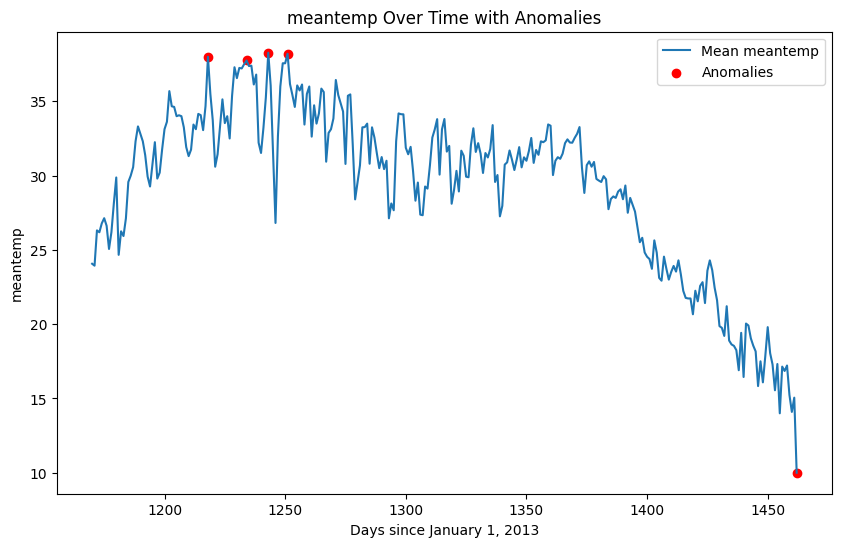

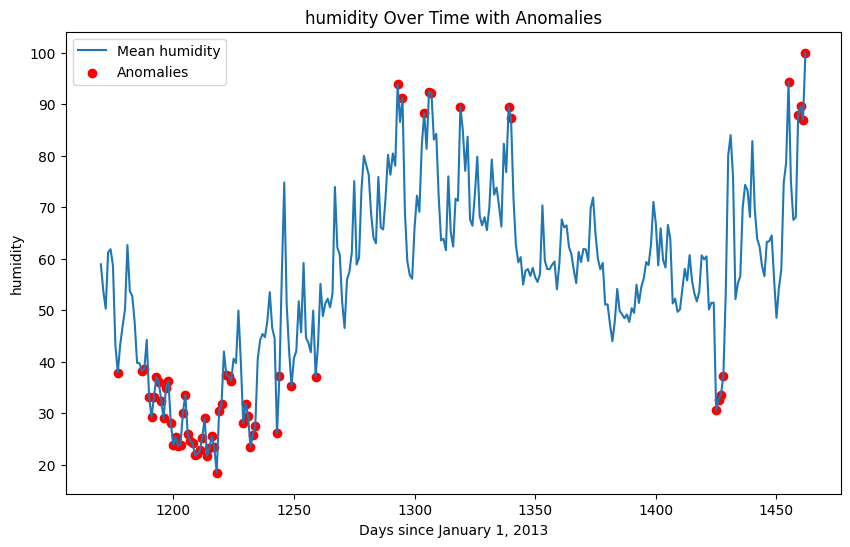

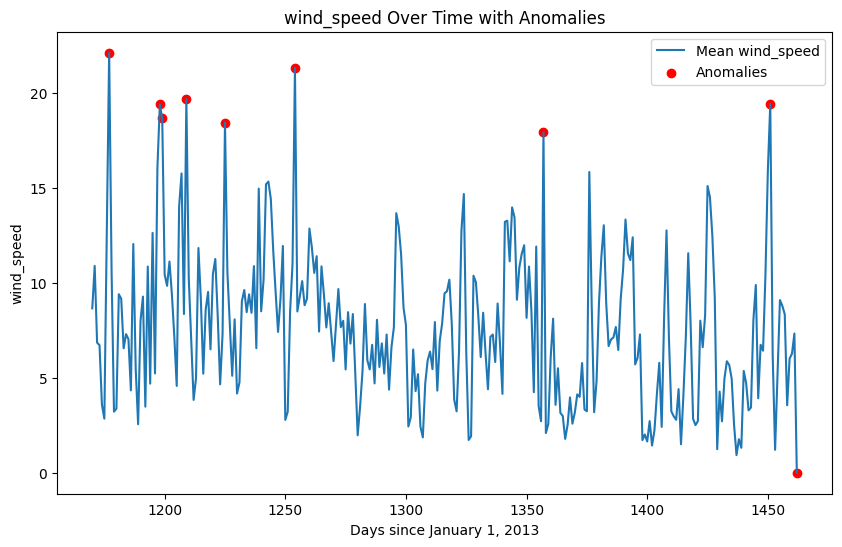

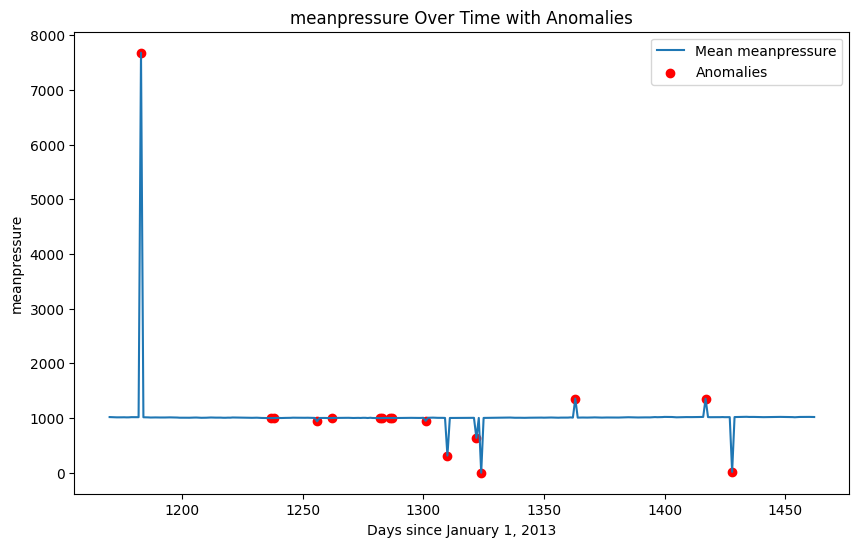

In [5]:
for col in df.columns[1:]:
    X = df[["date", col]]
    # subset the data
    prop = 0.8 * len(X)
    train = X[:int(prop)]
    test = X[int(prop):]

    # fit the model
    model = IsolationForest(n_estimators=100, max_samples= 200,
                            contamination=0.005, max_features= 1,
                            random_state=42)
    model.fit(train)
    anomalies = model.predict(test)

    # plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(test["date"], test[col], label="Mean " + col)
    plt.scatter(test["date"][anomalies == -1],
                test[col][anomalies == -1],
                color='red', label="Anomalies")
    plt.xlabel("Days since January 1, 2013")
    plt.ylabel(col)
    plt.title(col + " Over Time with Anomalies")
    plt.legend()
    plt.show()

# Gold Rates Data Analysis

## Dataset Description

The dataset contains the monthly closing prices of gold from 2014 to 2024, reflecting the market value of gold over time. This data is important for analyzing gold price trends, understanding market volatility, and identifying any unusual changes in the market. The dataset consists of 5 columns - dates and corresponding closing, opening, high and low prices and it needed some preprocessing to handle missing values, ensure correct date formats, and adjust for any trends or seasonality.

The data come from kaggle and can be accessed here: https://www.kaggle.com/code/gvyshnya/gold-future-prices-ts-comprehesive-eda?select=future-gc00-daily-prices.csv

Import all libraries, and mount the user's drive if needed

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
from prophet import Prophet
from sklearn.ensemble import IsolationForest

# suppress warnings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [14]:
# Load data from google drive
original_data = pd.read_csv("/content/drive/My Drive/Gold_prices.csv")

In [15]:
# Proceeding with cleaning the data
original_data['Date'] = pd.to_datetime(original_data['Date'], format='%m/%d/%Y')
gold_data = original_data[(original_data['Date'].dt.year >=2014) & (original_data['Date'].dt.year <= 2023)]


# clean numeric columns
for col in ['Open', 'High', 'Low', 'Close']:
    if gold_data[col].dtype != 'float64':  # If not already numeric
        gold_data.loc[:, col] = gold_data[col].str.replace(',', '').astype(float)

# View the data
gold_data.head()

,Date,Open,High,Low,Close
1,2014-01-02,1204.5,1230.8,1202.5,1225.2
2,2015-01-02,1184.0,1194.9,1167.3,1186.2
3,2018-01-02,1305.3,1320.4,1304.6,1316.1
4,2019-01-02,1285.0,1291.0,1280.6,1284.1
5,2020-01-02,1521.0,1534.0,1519.7,1528.1


## Exploratory Data Analysis (EDA)

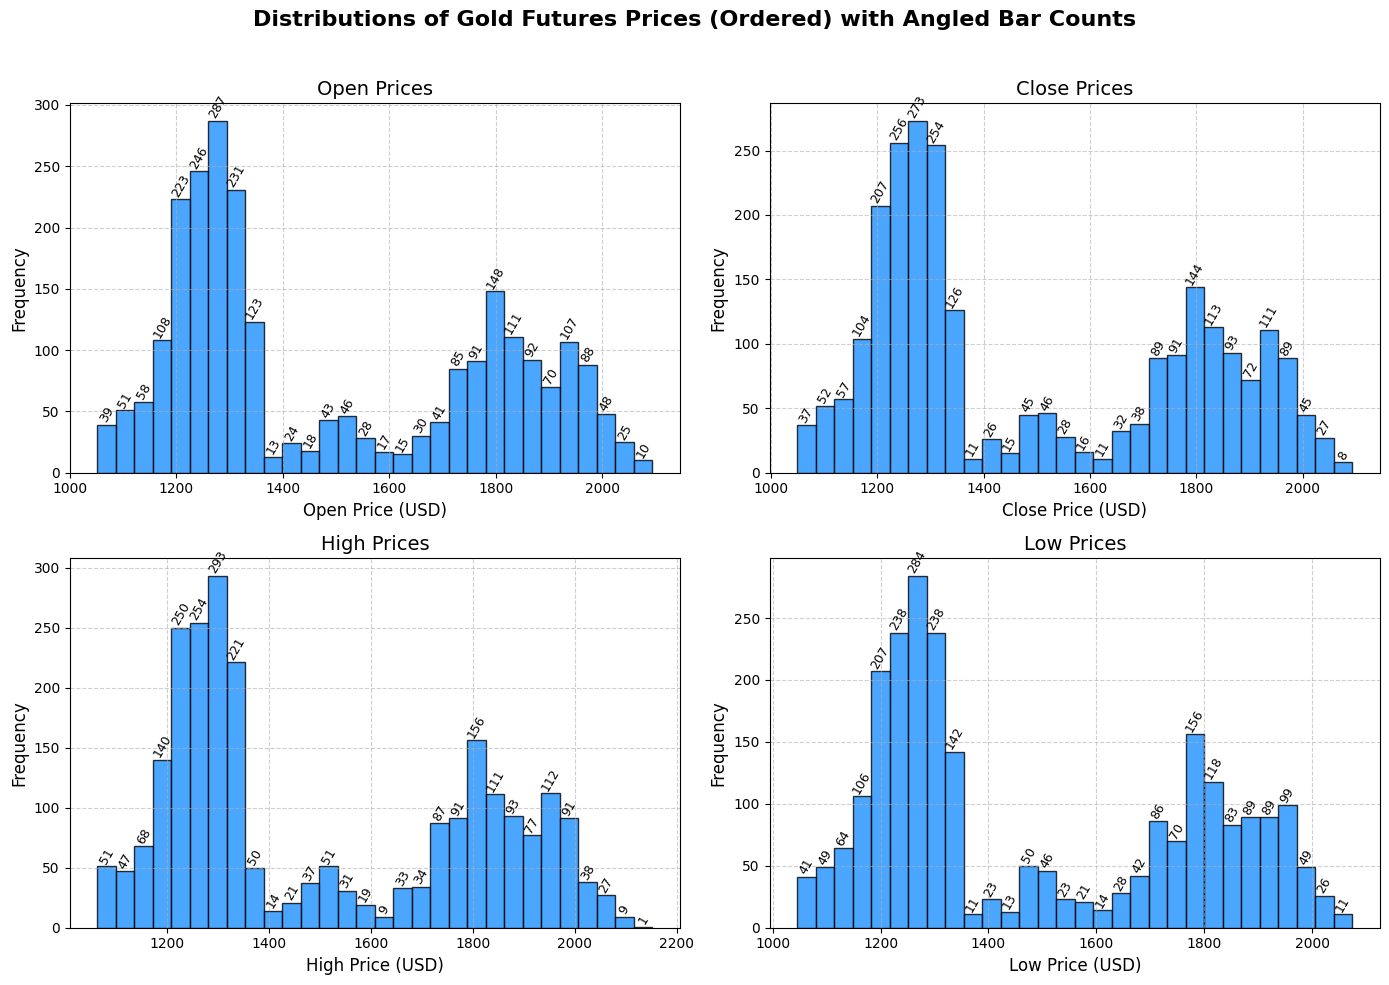

In [16]:
ordered_columns = ['Open', 'Close', 'High', 'Low']

# Plot the distribution of ordered numeric columns with angled count annotations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distributions of Gold Futures Prices (Ordered) with Angled Bar Counts', fontsize=16, fontweight='bold')

# List of ordered columns and their respective subplot locations
columns_and_axes = zip(ordered_columns, axes.flatten())

for col, ax in columns_and_axes:
    # Plot histogram
    counts, bins, patches = ax.hist(gold_data[col], bins=30, color='dodgerblue', edgecolor='black', alpha=0.8)

    # Annotate counts on top of each bar with angled text
    for count, bin_left, patch in zip(counts, bins, patches):
        if count > 0:  # Annotate only non-zero counts
            ax.text(
                bin_left + patch.get_width() / 2,
                count,
                f'{int(count)}',
                ha='center',
                va='bottom',
                fontsize=9,
                color='black',
                rotation=60
            )

    ax.set_title(f'{col} Prices', fontsize=14)
    ax.set_xlabel(f'{col} Price (USD)', fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.tick_params(axis='both', labelsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The graph shows the distributions of gold futures prices, including **open**, **close**, **high**, and **low** prices, with frequencies displayed for each price range. The **open** and **close** prices show peaks between 1,200 and
1,400, with close prices slightly higher. The **high prices** have a broader spread, with more occurrences between 1,500 and
1,800, and the **low prices** are concentrated around $1,200. Overall, most price points fall within a narrower range, with fewer extremes in the dataset.

## BASIC TIME SERIES ANALYSIS

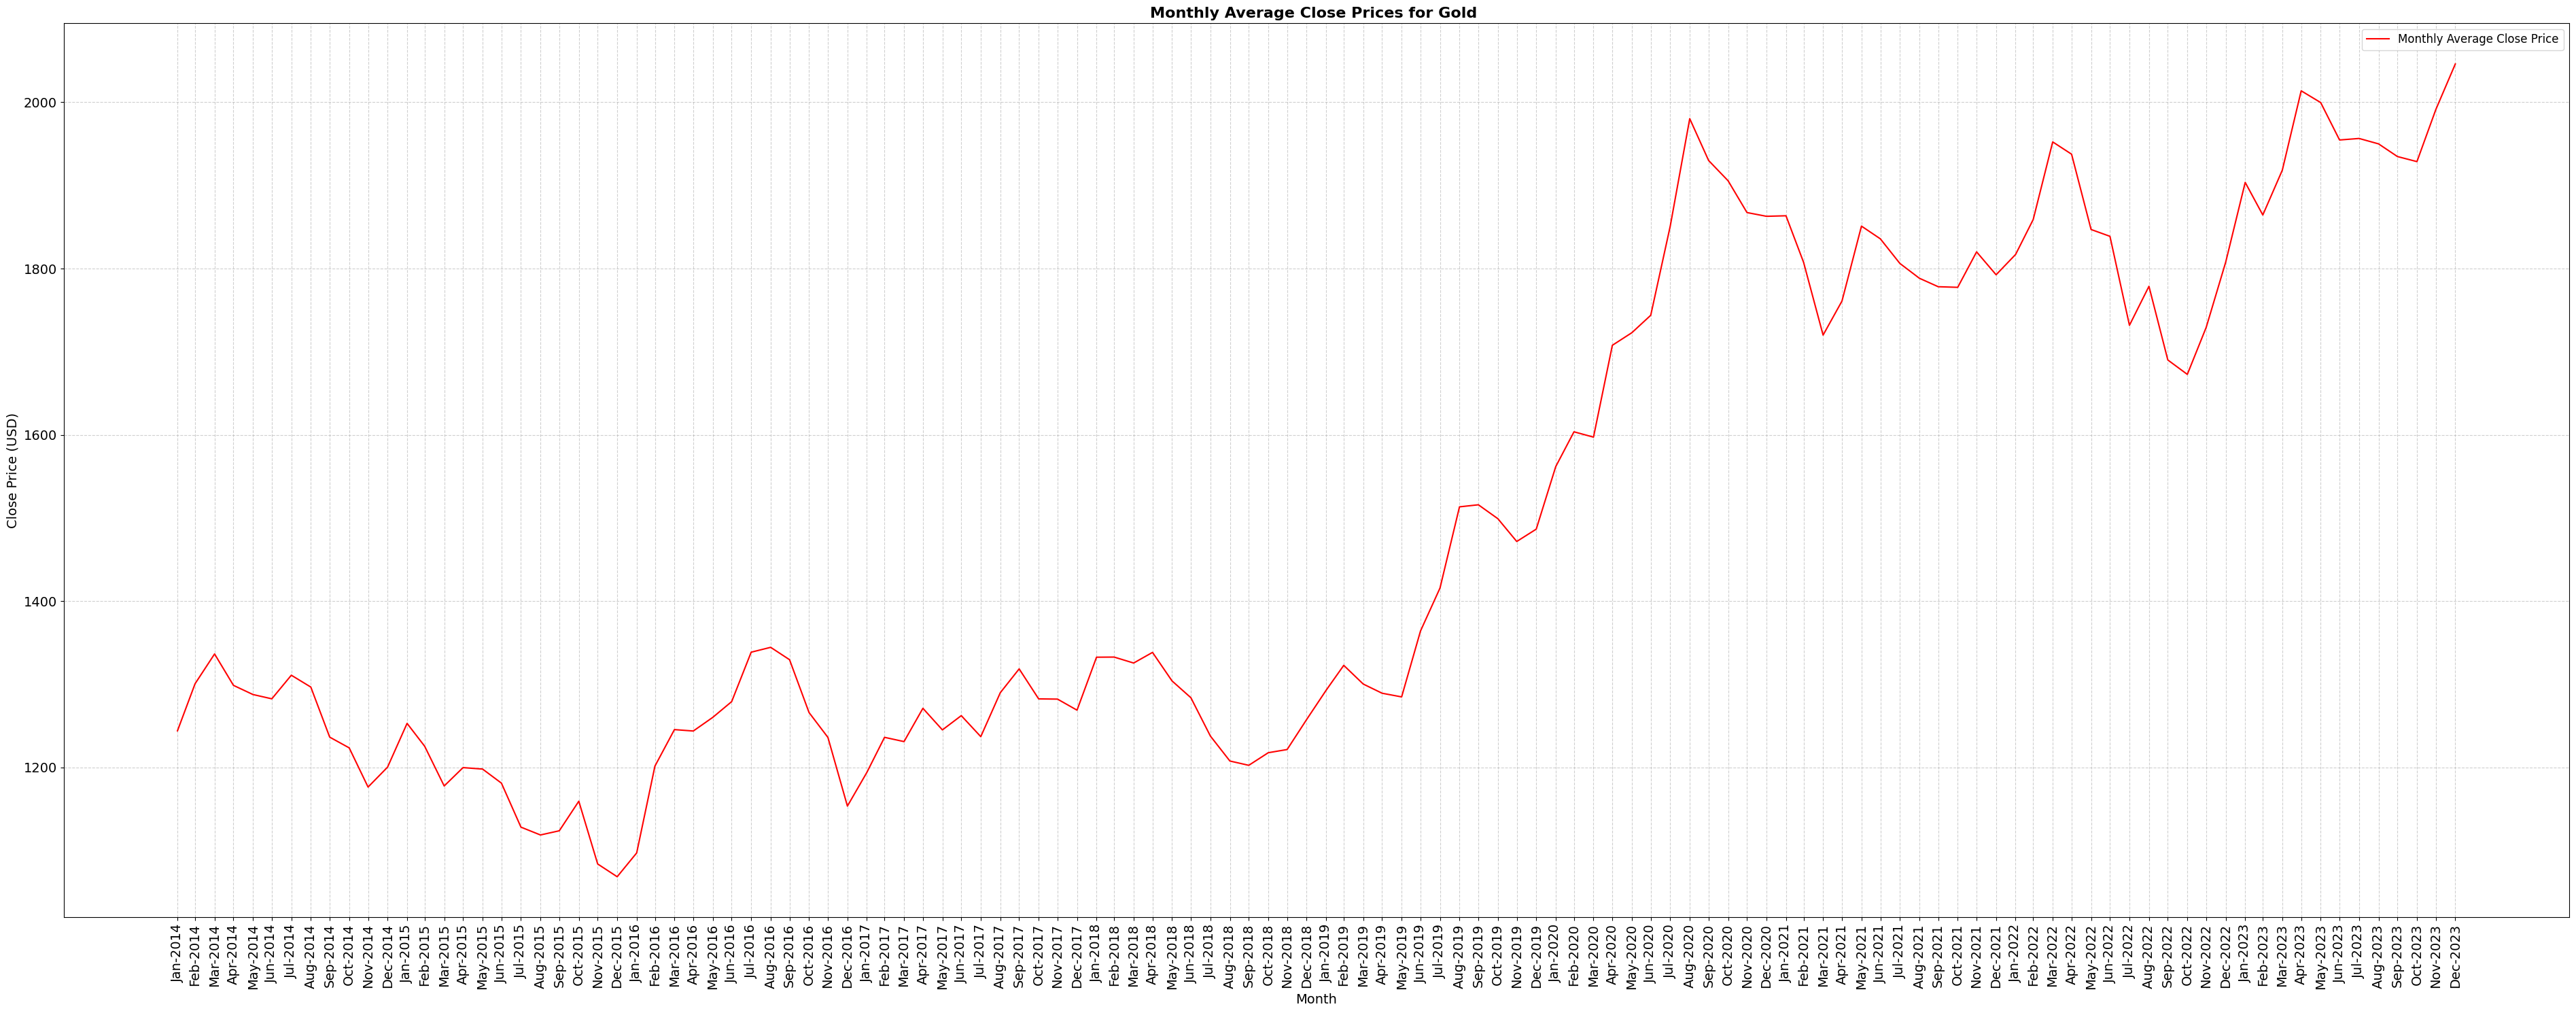

In [17]:
monthly_data = gold_data.resample('M', on='Date').mean()

# Plot close prices (monthly average)
plt.figure(figsize=(38, 15))
#plt.plot(monthly_data.index, monthly_data['Open'], label='Monthly Average Open Price', color='blue', linewidth=1.5)
plt.plot(monthly_data.index, monthly_data['Close'], label='Monthly Average Close Price', color='red', linewidth=1.5)
plt.title('Monthly Average Close Prices for Gold ', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=14, rotation=90)
plt.yticks(fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The graph shows the **monthly average close prices** for gold from January 2014 to December 2023. The price starts relatively low around $1,200 in early 2014, with fluctuations seen over the years. From 2018 onwards, there is a clear upward trend, with prices consistently rising. The steep increase in late 2019 and into 2020 marks a period of significant price growth, reflecting a major market shift, possibly driven by global economic conditions. The graph peaks sharply in the later months of 2022 and 2023, indicating a surge in gold prices, highlighting a period of increased demand or market instability.

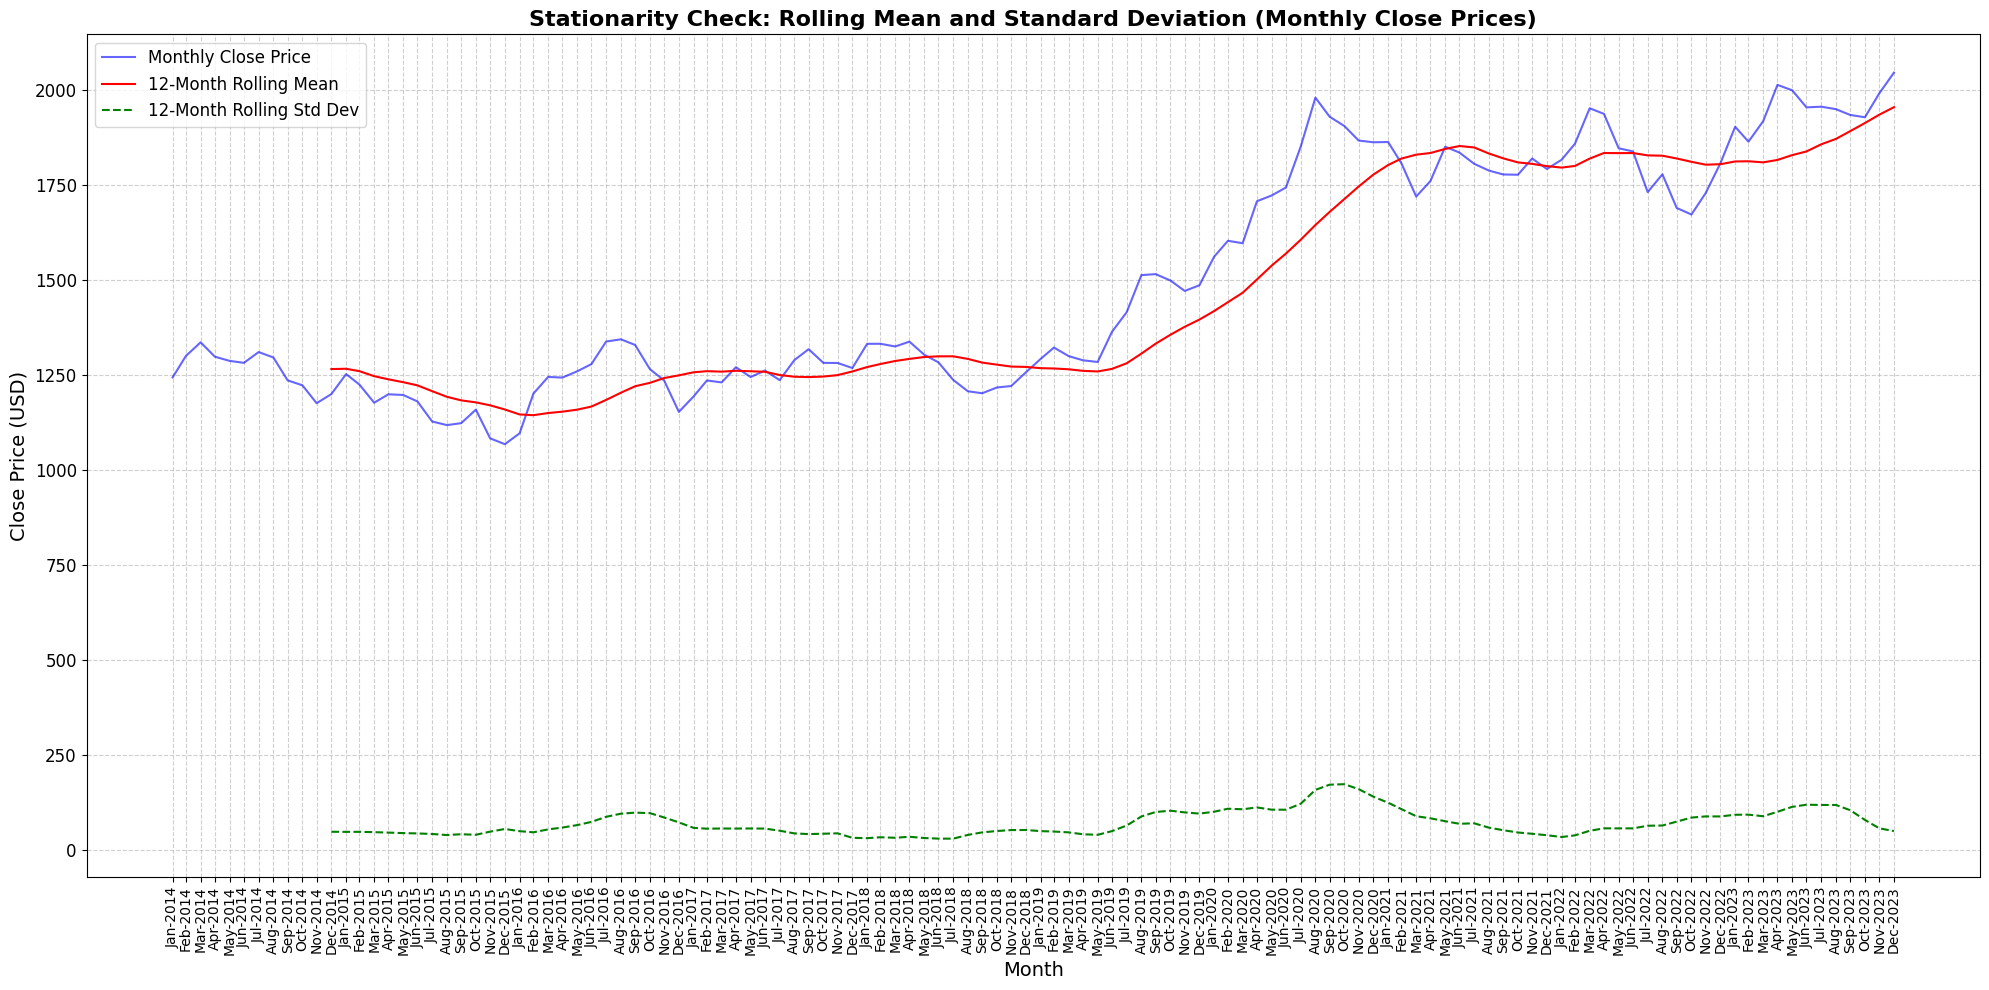

In [18]:
# Calculate rolling mean and standard deviation for monthly 'Close' prices
monthly_data['Rolling Mean'] = monthly_data['Close'].rolling(window=12).mean()  # 12 months rolling mean
monthly_data['Rolling Std'] = monthly_data['Close'].rolling(window=12).std()   # 12 months rolling standard deviation

# Plot the rolling mean and standard deviation to check stationarity
plt.figure(figsize=(20, 10))
plt.plot(monthly_data.index, monthly_data['Close'], color='blue', label='Monthly Close Price', alpha=0.6)
plt.plot(monthly_data.index, monthly_data['Rolling Mean'], color='red', label='12-Month Rolling Mean', linewidth=1.5)
plt.plot(monthly_data.index, monthly_data['Rolling Std'], color='green', label='12-Month Rolling Std Dev', linewidth=1.5, linestyle='--')
plt.title('Stationarity Check: Rolling Mean and Standard Deviation (Monthly Close Prices)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The graph shows a **stationarity check** for monthly close prices of gold, using the **rolling mean** and **rolling standard deviation**. The **blue line** represents the actual monthly close prices, which show an overall increasing trend over time, particularly after 2019. The **red line** shows the 12-month rolling mean, which follows a similar upward trajectory, confirming the trend in the gold prices. The **green dashed line** represents the 12-month rolling standard deviation, which remains relatively flat until around 2020, when it starts to rise, indicating increasing price volatility. This suggests that while the gold prices are trending upward, there are periods of increased fluctuation in recent years.

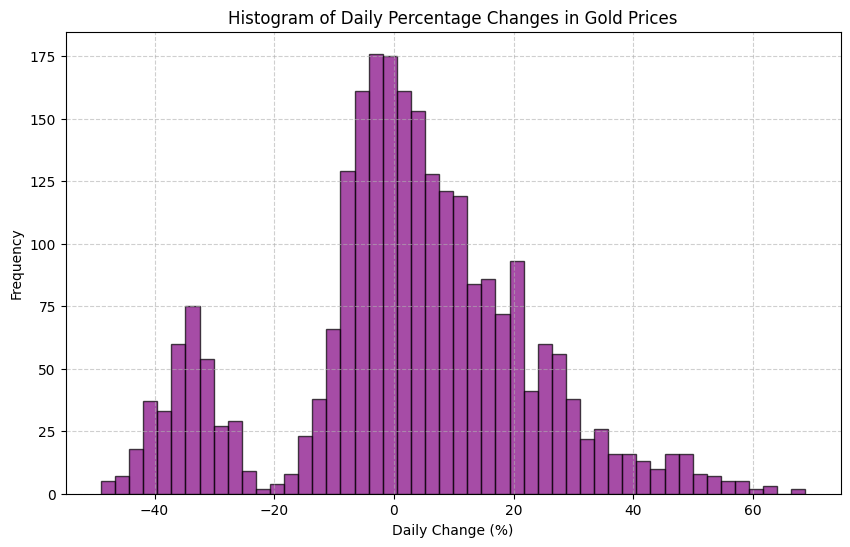

In [19]:
# votality analysis
gold_data['Daily Change (%)'] = gold_data['Close'].pct_change() * 100

# Plot the histogram of daily changes
plt.figure(figsize=(10, 6))
plt.hist(gold_data['Daily Change (%)'].dropna(), bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.title("Histogram of Daily Percentage Changes in Gold Prices")
plt.xlabel("Daily Change (%)")
plt.ylabel("Frequency")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

The histogram displays the **daily percentage changes** in gold prices, showing the frequency of different percentage changes. The distribution is roughly **bell-shaped**, with the majority of daily changes falling within a range of -20% to +20%. The peak near 0% suggests that small daily changes are the most common, indicating a relatively stable market most of the time. However, there are **tails** extending toward both negative and positive extremes, representing occasional large daily price fluctuations, though these are less frequent. The spread of the data highlights the occasional sharp movements in gold prices, but overall, the daily changes are generally small.

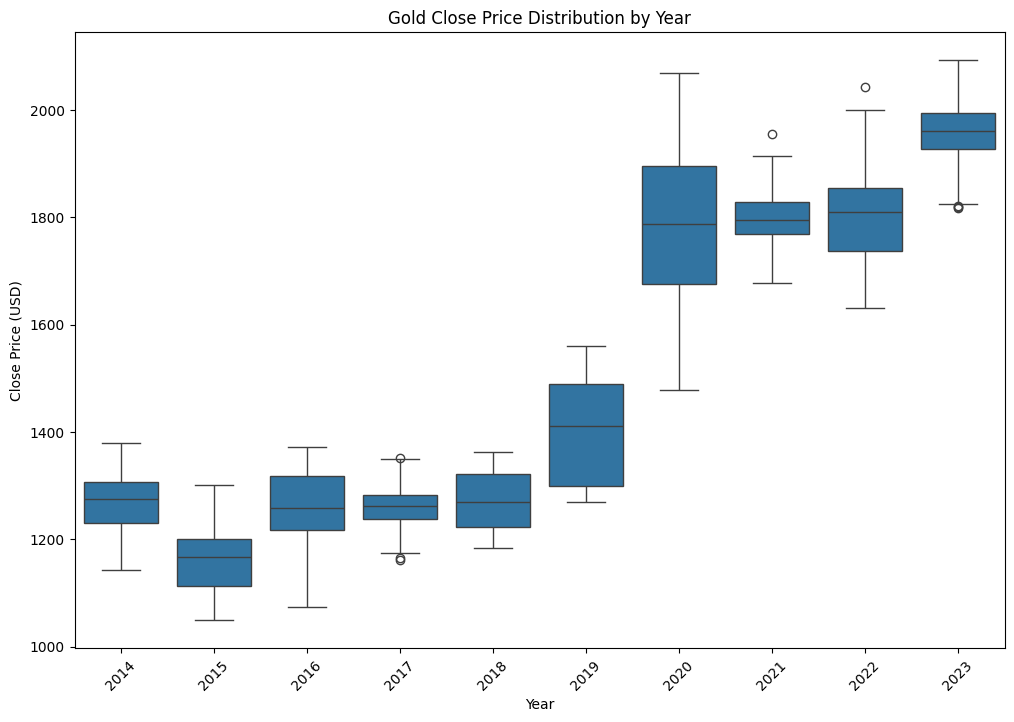

In [20]:
# trend over year
# extract year
gold_data['Year'] = gold_data['Date'].dt.year
plt.figure(figsize=(12, 8))
sns.boxplot(x='Year', y='Close', data=gold_data)
plt.title("Gold Close Price Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Close Price (USD)")
plt.xticks(rotation=45)
plt.show()

The boxplot shows the **distribution of gold close prices by year**, from 2014 to 2023. The plot reveals an overall upward trend in gold prices, with the median close price increasing over time. In 2014-2016, the prices are concentrated in the lower
1,300 range, while from 2017 onwards, the median rises significantly, especially in 2020 and 2022, reaching up to $1,800 and above. The interquartile range (the box) also widens in the later years, indicating increasing price volatility. Outliers appear in several years, particularly after 2020, suggesting occasional extreme price fluctuations. This highlights a period of significant market movements and the increasing value of gold.

## Anomaly Detection

Now, models for anomaly detection can be explored.

In [21]:
# Drop Na/ Nan values
monthly_close_prices = monthly_data['Close'].dropna()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27_4uea/8gmbu031.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27_4uea/rvyu9akl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23299', 'data', 'file=/tmp/tmpq27_4uea/8gmbu031.json', 'init=/tmp/tmpq27_4uea/rvyu9akl.json', 'output', 'file=/tmp/tmpq27_4uea/prophet_modelo0aqasqs/prophet_model-20241213232735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:27:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:27:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


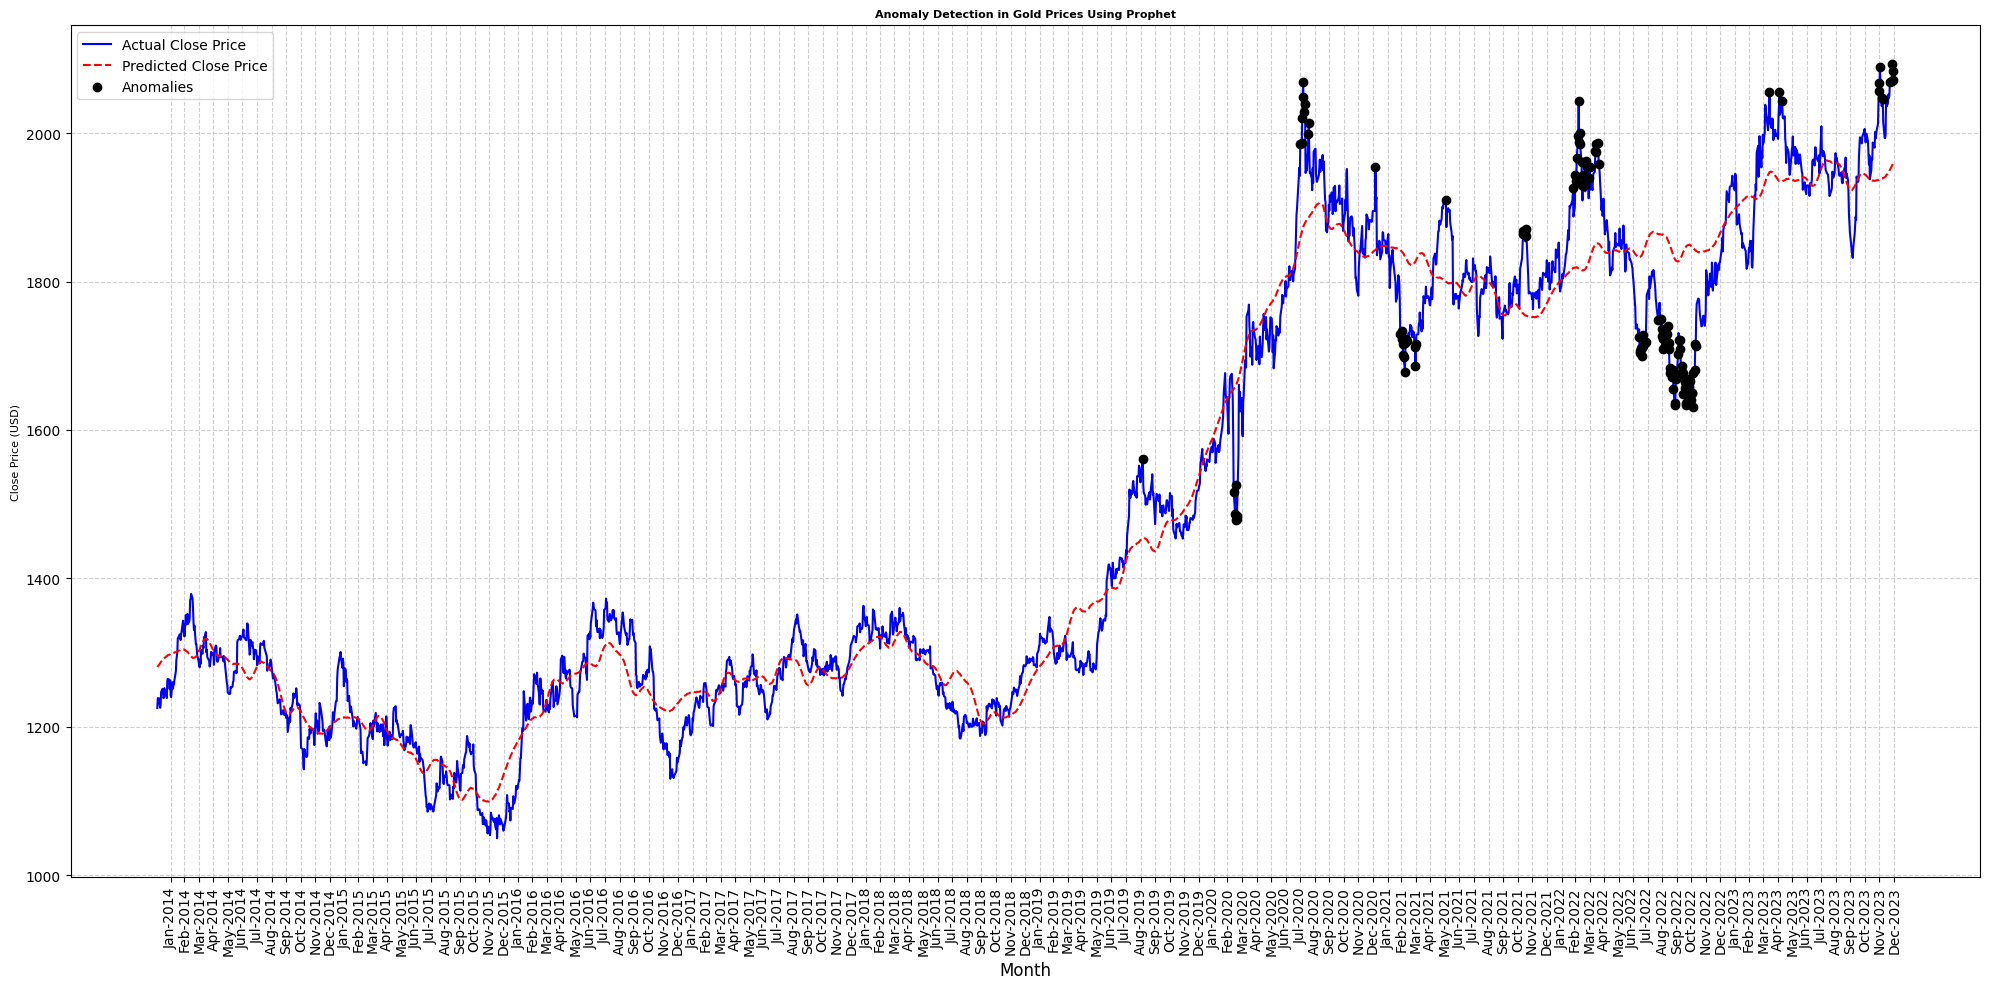

,ds,y,residual
1427,2019-09-04,1560.4,106.802392
1559,2020-03-13,1516.7,-138.463406
1560,2020-03-16,1486.5,-171.126381
1561,2020-03-17,1525.8,-133.002883
1562,2020-03-18,1477.9,-182.250502


In [22]:
# sort the data
gold_data = gold_data.sort_values(by='Date')

# Filter data for the years 2014 to 2023
filtered_gold_data = gold_data[(gold_data['Date'].dt.year >= 2014) & (gold_data['Date'].dt.year <= 2023)]

# Prepare the data for Prophet
prophet_data = filtered_gold_data[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Drop missing values
prophet_data = prophet_data.dropna()

# Initialize and fit the Prophet model
model = Prophet()
model.fit(prophet_data)

# Create a future dataframe with additional periods for prediction (IF NEEDED)
future = model.make_future_dataframe(periods= 0, freq = 'M')
forecast = model.predict(future)

# Merge actual data into the forecast to calculate residuals
forecast = forecast.merge(prophet_data, on='ds', how='left')
forecast['residual'] = forecast['y'] - forecast['yhat']

# Define an adjustable threshold for anomalies (e.g., 2 standard deviations)

threshold = 2 * forecast['residual'].std()

# Flag anomalies based on the threshold
forecast['anomaly'] = np.abs(forecast['residual']) > threshold

# Plot the results
plt.figure(figsize=(20, 10))
plt.plot(forecast['ds'], forecast['y'], label='Actual Close Price', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Close Price', color='red', linestyle='--')
plt.scatter(
    forecast[forecast['anomaly'] == True]['ds'],
    forecast[forecast['anomaly'] == True]['y'],
    color='black',
    label='Anomalies',
    zorder=2
)

plt.title('Anomaly Detection in Gold Prices Using Prophet', fontsize=8, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=8)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.tight_layout()
plt.show()

# Display the anomalies
anomalies = forecast[forecast['anomaly'] == True][['ds', 'y', 'residual']]

anomalies.head(5)

The graph shows anomaly detection in gold prices using the Prophet model, with the blue line representing the actual close prices and the red dashed line showing the predicted close prices. The black dots indicate the detected anomalies, where the actual prices deviate significantly from the predicted values. Notably, anomalies appear throughout the timeline, particularly around early 2020 and late 2021, with some extreme spikes and drops in price. These anomalies likely reflect market events or fluctuations that were not captured by the underlying trend, indicating times of significant market disruption or volatility.

### Performance of the Model

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Filter forecast for only the available actual data
forecast_with_actuals = forecast.dropna(subset=['y'])

# Calculate the metrics
mae = mean_absolute_error(forecast_with_actuals['y'], forecast_with_actuals['yhat'])
mape = np.mean(np.abs((forecast_with_actuals['y'] - forecast_with_actuals['yhat']) / forecast_with_actuals['y'])) * 100
rmse = np.sqrt(mean_squared_error(forecast_with_actuals['y'], forecast_with_actuals['yhat']))
r2 = r2_score(forecast_with_actuals['y'], forecast_with_actuals['yhat'])

# Print the metrics
print("Performance Metrics for Prophet Model:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Performance Metrics for Prophet Model:
Mean Absolute Error (MAE): 38.88
Mean Absolute Percentage Error (MAPE): 2.56%
Root Mean Square Error (RMSE): 52.87
R² Score: 0.97


The MAE of 38.56 indicates that, on average, the model’s predictions deviate from the actual gold prices by $38.56. The MAPE of 2.53% shows that the model is highly accurate, with predictions being only 2.53% off from the actual values on average. The RMSE of 52.59 suggests that the model performs well, with relatively few large errors. Finally, the R² score of 0.97 indicates that the model explains 97% of the variance in the gold prices, which means it captures most of the trends and patterns in the data. These metrics demonstrate that the Prophet model is effective for forecasting gold prices with high accuracy.

In [24]:
# Apply first-order differencing to the monthly 'Close' prices
monthly_data['Differenced Close'] = monthly_data['Close'].diff()

# Perform ADF test on differenced data
differenced_close_prices = monthly_data['Differenced Close'].dropna()
adf_test_diff = adfuller(differenced_close_prices)
adf_results_diff = {
    "ADF Statistic": adf_test_diff[0],
    "p-value": adf_test_diff[1],
    "Critical Values": adf_test_diff[4],
    "Is Stationary": adf_test_diff[1] < 0.05
}

adf_results_diff

{'ADF Statistic': -8.822740832722776,
 'p-value': 1.858291055790545e-14,
 'Critical Values': {'1%': -3.4870216863700767,
  '5%': -2.8863625166643136,
  '10%': -2.580009026141913},
 'Is Stationary': True}

The results from the Augmented Dickey-Fuller (ADF) test indicate that the time series is stationary. The ADF statistic of -8.82 is significantly smaller than the critical values at the 1%, 5%, and 10% levels, which are -3.49, -2.89, and -2.58, respectively. The p-value of 1.86e-14 is extremely small, confirming that we can reject the null hypothesis of non-stationarity. This suggests that the series does not have a unit root and its statistical properties, such as mean and variance, do not change over time, making it suitable for time-series modeling.

In [25]:
# Exponential smoothing
alpha = 0.5  # Smoothing factor
monthly_data['Smoothed Close'] = monthly_data['Close'].ewm(alpha=alpha, adjust=False).mean()

# Perform ADF test on exponentially smoothed data
smoothed_close_prices = monthly_data['Smoothed Close'].dropna()
adf_test_smoothed = adfuller(smoothed_close_prices)
adf_results_smoothed = {
    "ADF Statistic": adf_test_smoothed[0],
    "p-value": adf_test_smoothed[1],
    "Critical Values": adf_test_smoothed[4],
    "Is Stationary": adf_test_smoothed[1] < 0.05
}

adf_results_smoothed

{'ADF Statistic': 0.01623833365311663,
 'p-value': 0.9598545595136267,
 'Critical Values': {'1%': -3.487517288664615,
  '5%': -2.8865777180380032,
  '10%': -2.5801239192052012},
 'Is Stationary': False}

The results from the Augmented Dickey-Fuller (ADF) test indicate that the time series is non-stationary. The ADF statistic of 0.0162 is much higher than the critical values at the 1%, 5%, and 10% levels, which are -3.49, -2.89, and -2.58, respectively. The p-value of 0.96 is very high, meaning we cannot reject the null hypothesis of non-stationarity. This suggests that the series has a unit root and its statistical properties, such as mean and variance, change over time, indicating that the data requires differencing or other transformations to make it stationary for time-series modeling.

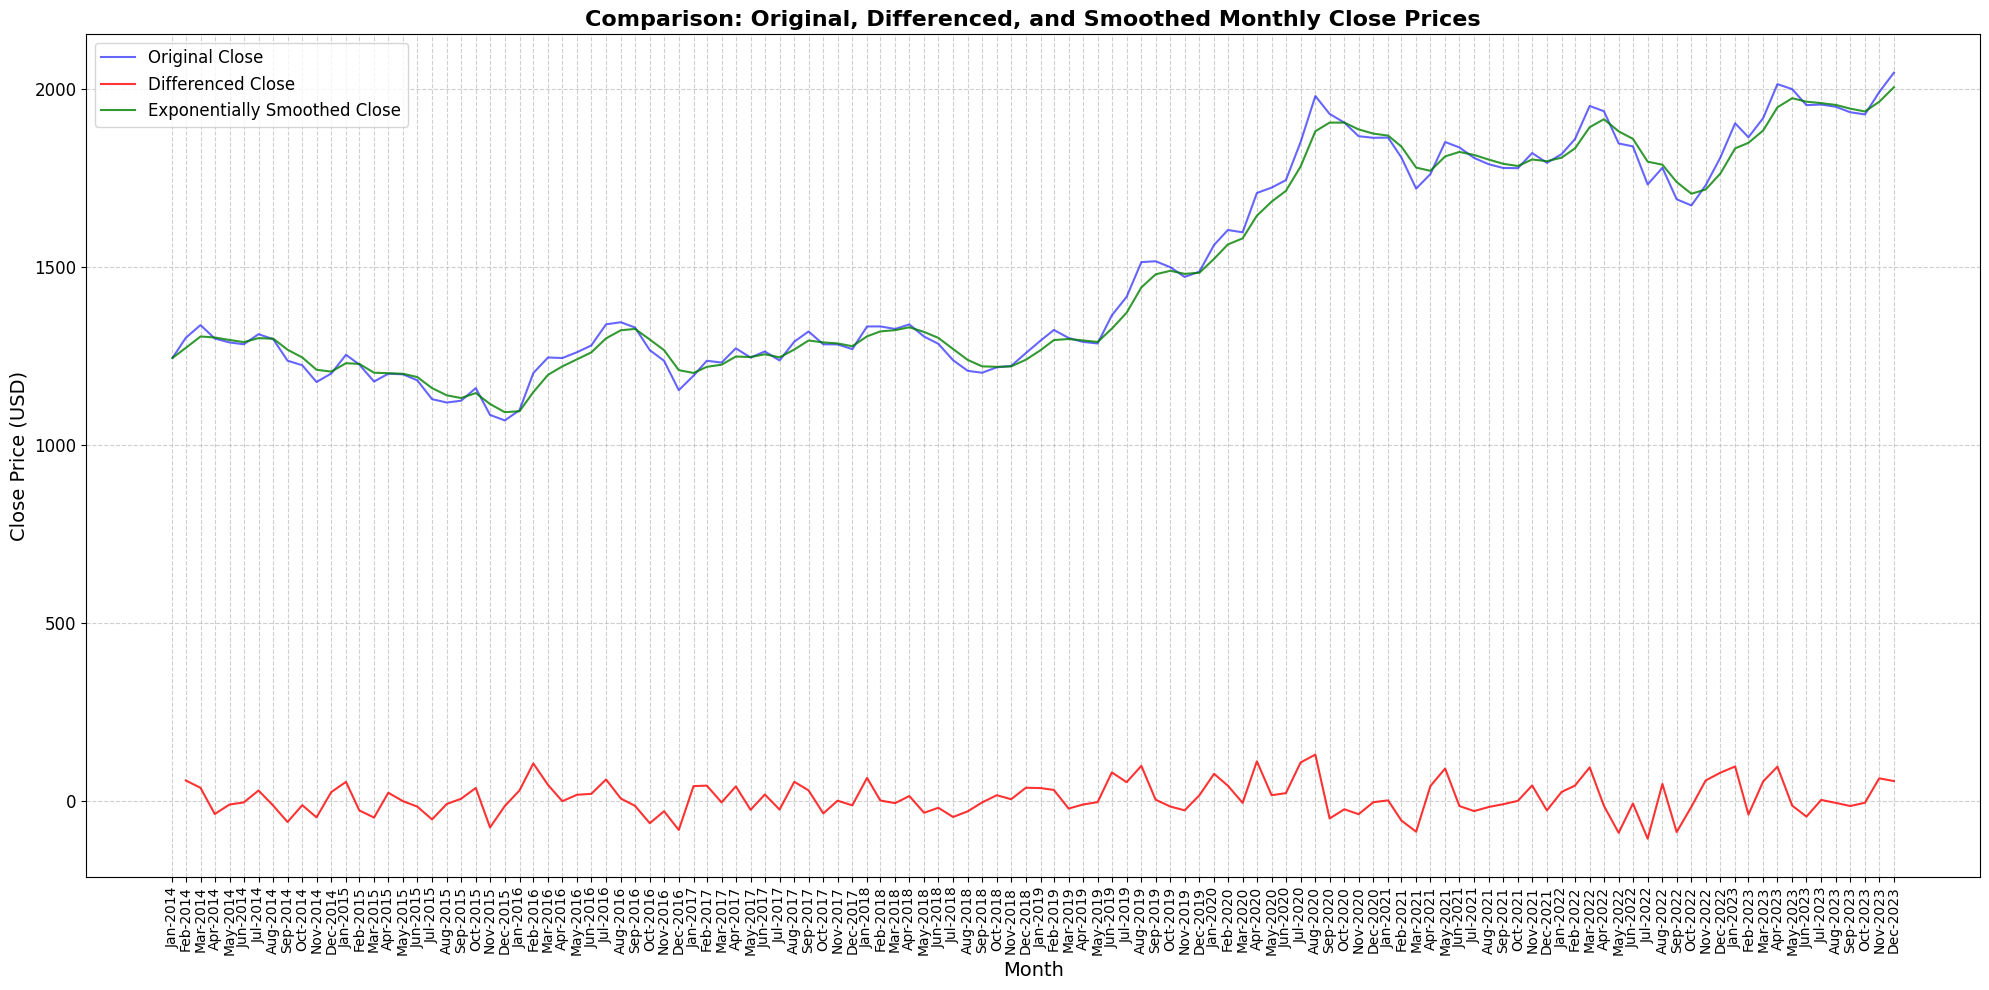

In [26]:
# Plot the original, differenced, and smoothed data
plt.figure(figsize=(20, 10))
plt.plot(monthly_data.index, monthly_data['Close'], label='Original Close', color='blue', alpha=0.6)
plt.plot(monthly_data.index, monthly_data['Differenced Close'], label='Differenced Close', color='red', alpha=0.8)
plt.plot(monthly_data.index, monthly_data['Smoothed Close'], label='Exponentially Smoothed Close', color='green', alpha=0.8)
plt.title('Comparison: Original, Differenced, and Smoothed Monthly Close Prices', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Close Price (USD)', fontsize=14)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The graph compares the original, differenced, and exponentially smoothed monthly close prices of gold. The blue line represents the original close prices, showing the typical fluctuations in gold prices over time. The green line represents the exponentially smoothed close prices, which smooth out the fluctuations to highlight the underlying trend. The red line shows the differenced prices, emphasizing the changes between consecutive months. The differenced data reveals much more volatility, while the smoothed prices show a clearer, steady upward trend, especially in recent years, reflecting increasing gold prices. This comparison indicates how differencing removes trends and smoothing highlights the long-term movement.

In [27]:
# Use auto_arima to find the best ARIMA parameters
auto_arima_model = auto_arima(
    monthly_close_prices,
    start_p=0, max_p=5,  # Range for AR terms
    start_q=0, max_q=5,  # Range for MA terms
    d=1,                 # Differencing order (1 since we've already differenced)
    seasonal=False,      # No seasonality assumed
    trace=True,          # Display progress
    error_action='ignore',  # Ignore errors
    suppress_warnings=True, # Suppress warnings
    stepwise=True         # Use a stepwise search for efficiency
)

# Summary of the best model
best_model_params = auto_arima_model.get_params()
best_model_params

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1256.840, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1254.127, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1253.591, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1257.286, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1255.586, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1255.582, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=3.92 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1253.389, Time=0.15 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1255.387, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1255.385, Time=0.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1253.846, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1257.239, Time=1.15 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 7.433 seconds


{'maxiter': 50,
 'method': 'lbfgs',
 'order': (0, 1, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

The best model identified by auto_arima is ARIMA(0,1,1), indicating a first-order differencing and one moving average term.

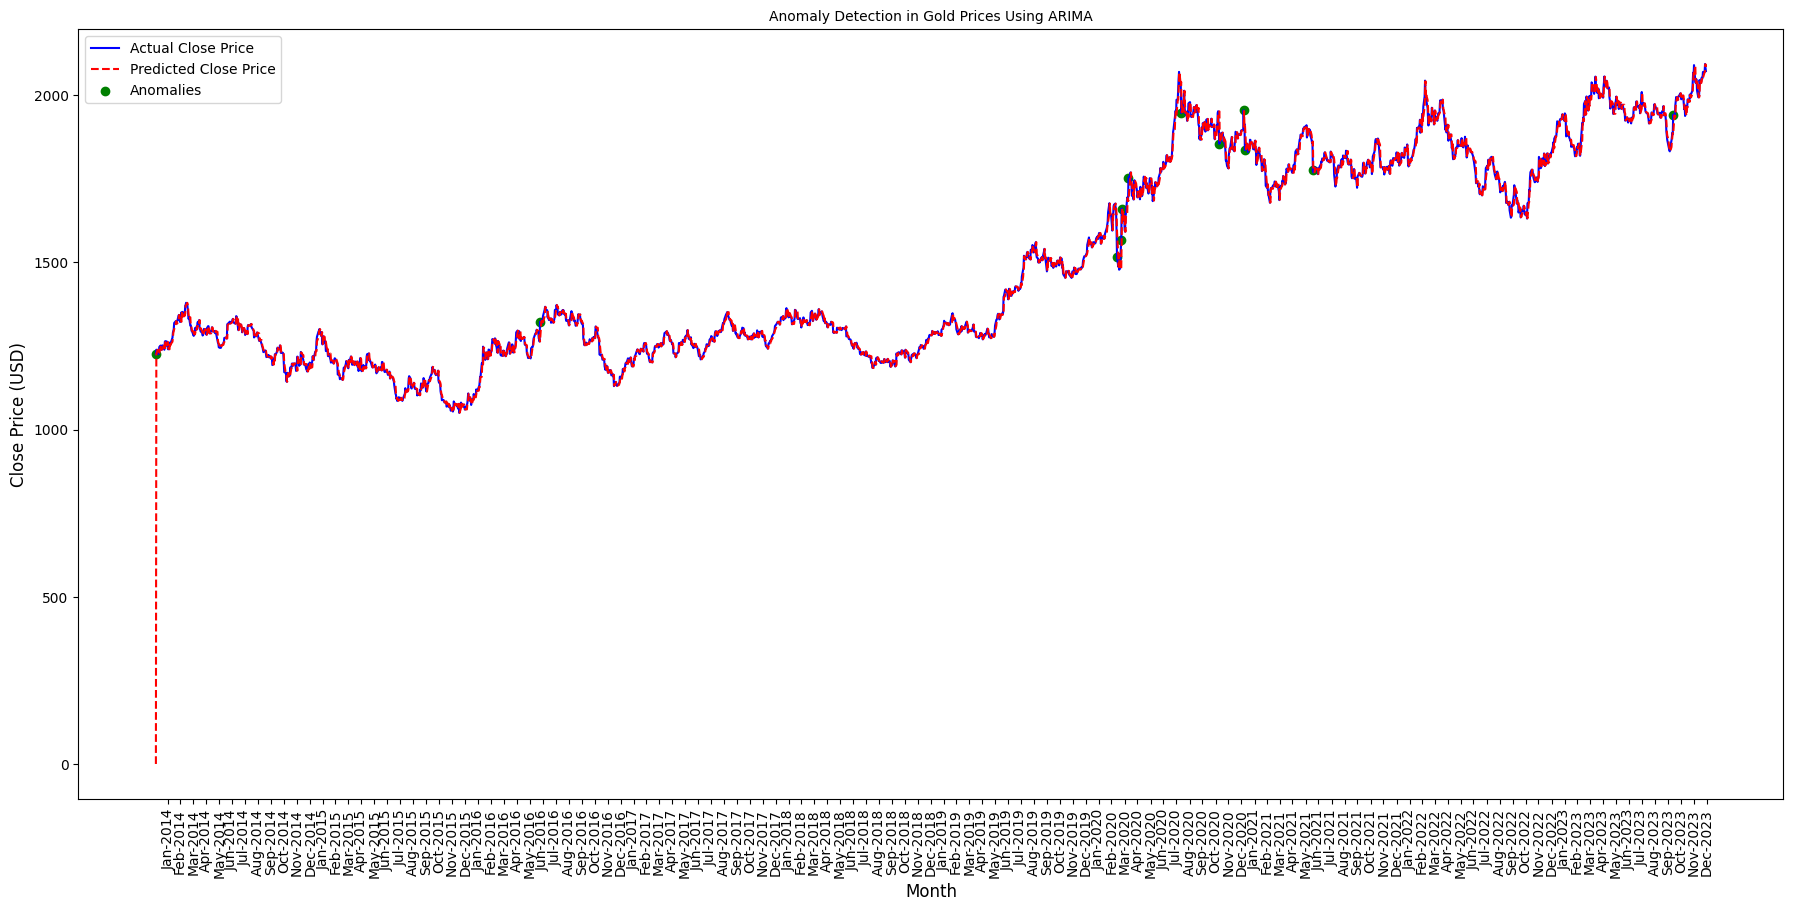

,Close Price (Anomalies)
Date,
2014-01-02,1225.200000
2016-06-24,59.042981
2020-03-13,-75.529282
2020-03-23,83.193695
2020-03-24,96.246792
2020-04-09,68.510678
2020-08-11,-93.025999
2020-11-09,-97.053346
2021-01-05,59.302800


In [32]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the data
gold_data['Date'] = pd.to_datetime(gold_data['Date'], format='%d/%m/%Y')
filtered_gold_data = gold_data[(gold_data['Date'].dt.year >= 2014) & (gold_data['Date'].dt.year <= 2023)]
arima_data = filtered_gold_data[['Date', 'Close']].set_index('Date').dropna()

# Convert the 'Close' column to numeric, handling potential errors
arima_data['Close'] = pd.to_numeric(arima_data['Close'], errors='coerce')

# Fit the ARIMA model (you may want to experiment with different p, d, q parameters)
model = ARIMA(arima_data['Close'], order=(0,1,1))
model_fit = model.fit()

# Predict the values
predictions = model_fit.predict(start=0, end=len(arima_data)-1, typ='levels')

# Calculate residuals (actual - predicted)
residuals = arima_data['Close'] - predictions

# Define a threshold for anomalies (e.g., 2 standard deviations)
threshold = 2 * residuals.std()

# Flag anomalies based on the threshold
anomalies = residuals[abs(residuals) > threshold]

# Plot the results
plt.figure(figsize=(22, 10))
plt.plot(arima_data.index, arima_data['Close'], label='Actual Close Price', color='blue')
plt.plot(arima_data.index, predictions, label='Predicted Close Price', color='red', linestyle='--')
plt.scatter(anomalies.index, arima_data.loc[anomalies.index, 'Close'], color='green', label='Anomalies')
plt.title('Anomaly Detection in Gold Prices Using ARIMA', fontsize=10)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Close Price (USD)', fontsize=12)
plt.xticks(monthly_data.index, monthly_data.index.strftime('%b-%Y'), fontsize=10, rotation=90)
plt.legend()
plt.show()

anomalies_df = pd.DataFrame({
    'Date': anomalies.index,
    'Close Price (Anomalies)': anomalies.values
}).set_index('Date')


anomalies_df

The graph displays anomaly detection in gold prices using the ARIMA model, with the blue line representing the actual close prices and the red dashed line showing the predicted values. The green dots highlight the anomalies, where the actual prices significantly deviate from the predicted trend. Notable anomalies are detected, especially around January 2014, where the price sharply drops, as well as several points throughout the timeline, particularly during periods of rapid price changes. These anomalies indicate unusual market behavior or potential outliers that were not captured by the ARIMA model's forecast.

In [33]:
# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(residuals**2))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs(residuals) / arima_data['Close']) * 100

# Calculate R-squared (R²)
ss_total = np.sum((arima_data['Close'] - arima_data['Close'].mean())**2)
ss_residual = np.sum(residuals**2)
r_squared = 1 - (ss_residual / ss_total)

# Print the evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
print(f'R² Score: {r_squared}')

Mean Absolute Error (MAE): 10.454115457360333
Root Mean Squared Error (RMSE): 28.388856611301453
Mean Absolute Percentage Error (MAPE): 0.6962973452712539%
R² Score: 0.9908198057630713


The MAE of 10.45 indicates that, on average, the model's predictions are off by $10.45, which is a very small error considering the scale of the data. The RMSE of 28.39 confirms that most of the errors are small, with fewer large deviations. The MAPE of 0.70% shows that the model is highly accurate, with predictions being less than 1% off from the actual values on average. Finally, the R² score of 0.99 indicates that the ARIMA model explains 99% of the variance in the gold prices, which is an excellent result, demonstrating the model's strong ability to capture the overall trend and make accurate forecasts.

# General Overview and Conclusions

Both the Prophet and ARIMA models are widely used for time-series forecasting, but they differ in their approaches to modeling and anomaly detection. After evaluating both models based on their predictive accuracy and anomaly detection capabilities, we can compare their performance metrics to understand their strengths and weaknesses.

The ARIMA model is particularly effective at detecting anomalies in the gold prices because it closely tracks short-term deviations from the expected trend. It's low MAE and RMSE values show that the model is very accurate in its predictions. However, ARIMA's strength lies in short-term forecasting and anomaly detection rather than capturing long-term trends. On the other hand, the Prophet model excels in handling long-term trends and seasonality. It works well when the goal is to forecast future gold prices over a longer time horizon and handle missing data.

# Cloud Network Data Analysis

## Dataset Description

The dataset used for this project consists of real network traffic data from a single website server, available [here](https://www.kaggle.com/datasets/garystafford/ping-data). It contains the following:

- Ping measurements across several days

- Regular server requests

- Instances of extended high ping, indicating an attack or server overload

Specifically, the two variables that will be analyzed are in the table below.



| Variable   | Description                           |
|------------|---------------------------------------|
| timestamp  | Time of request                      |
| local_avg  | Average ping of all users at a given time |

## Methods

Two statistical and machine learning approaches are implemented to model the network traffic data and detect anomalies.

1. Prophet

  - Designed by Facebook for time-series forecasting
  - Captures trends, seasonality, and outliers
  - Good for data with regular patterns and occasional anomalies


2. ARIMA (Auto-Regressive Integrated Moving Average)

    - A classical time-series model
    - Models temporal tendencies
    - Good for detecting deviations in linear trends

## Results

The results for the implementation were done in Python on Google Colab, assuming that the dataset is on the user's google drive homepage.

Relevant graphics are generated, and interpretations are given after each graph.


#### Import all necessary libraries, and mount the user's drive if needed

In [34]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from prophet import Prophet
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.arima.model import ARIMA

In [35]:
# Import data from google drive if applicable
df = pd.read_csv("/content/drive/My Drive/ping_data.csv")

#### Data Preproccessing

Load in the data, isolate desired columns

In [36]:
# Read in data from local machine if applicable
# df = pd.read_csv('data/raw/ping_data.csv')

# Subset necessary columns
ping_data = df[['timestamp', 'local_avg']]

# Convert seconds to dates
ping_data['timestamp'] = pd.to_datetime(ping_data['timestamp'], unit='s')

# Subset data
ping_data = ping_data.iloc[:100]

#### Distribution of the dataset

The dataset can be visualized to get a better grasp of the relationship between time and ping.

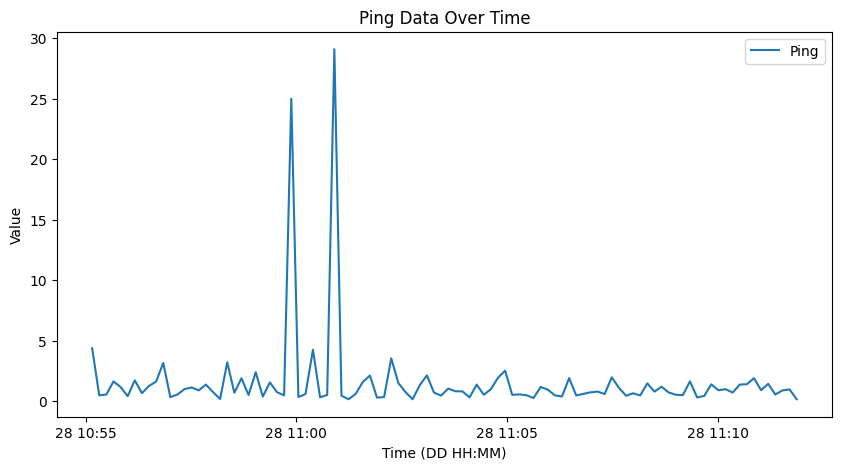

In [37]:
# Define X and Y variables for plotting
x = ping_data['timestamp']
y = ping_data['local_avg']

# Plot graph
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Ping')
plt.title('Ping Data Over Time')
plt.xlabel('Time (DD HH:MM)')
plt.ylabel('Value')
plt.legend()
plt.show()

From the graph, we see some clear abnormalities, potetially indicating high traffic volume.

Now, we can fit the time series models to the data.

### Prophet Model

In [38]:
# Split data into train and test
# 70% training (History), 30% test (To Forecast)
ping_data.rename(columns={'timestamp':'ds', 'local_avg': 'y'}, inplace=True)
train_size = int(0.7 * len(ping_data))
train = ping_data[:train_size]
test = ping_data[train_size:]

In [39]:
# Train Prophet model
model = Prophet()
model.fit(train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27_4uea/526nd6gr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpq27_4uea/4o97g98f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82006', 'data', 'file=/tmp/tmpq27_4uea/526nd6gr.json', 'init=/tmp/tmpq27_4uea/4o97g98f.json', 'output', 'file=/tmp/tmpq27_4uea/prophet_model6iityn68/prophet_model-20241213233426.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:34:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:34:26 - cmdstanpy - INFO - Chai

In [40]:
# Predict on training data
train_forecast = model.predict(train[['ds']])

# Combine relevant columns into training data for plotting
train['yhat'] = train_forecast['yhat']
train['residuals'] = train['y'] - train['yhat']

In [41]:
# Detect anomalies in training data using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)

# Combine anomaly predictions to training data, and flag anomalies
train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True

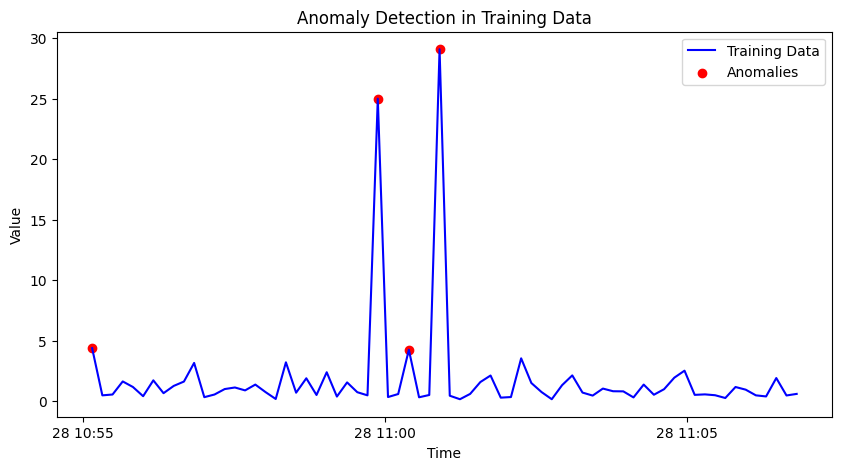

In [42]:
# Plot anomalies detected in training data
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.scatter(train['ds'][train['anomaly']], train['y'][train['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Training Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

At a glance, the algorithm seems to be doing well. It detects the obvious anomalies, and it also detects anomalies that are slightly higher than the desired ping values.

In [43]:
# Predict on test data
test_forecast = model.predict(test[['ds']])

# Combine relevant columns into test data for plotting
test['yhat'] = test_forecast.loc[test_forecast['ds'].isin(test['ds']), 'yhat'].values
test['residuals'] = test['y'] - test['yhat']

In [44]:
# Detect anomalies in test data using Isolation Forest
test['anomaly'] = iso_forest.predict(test[['residuals']])

# Combine anomalies with test data and flag
test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True

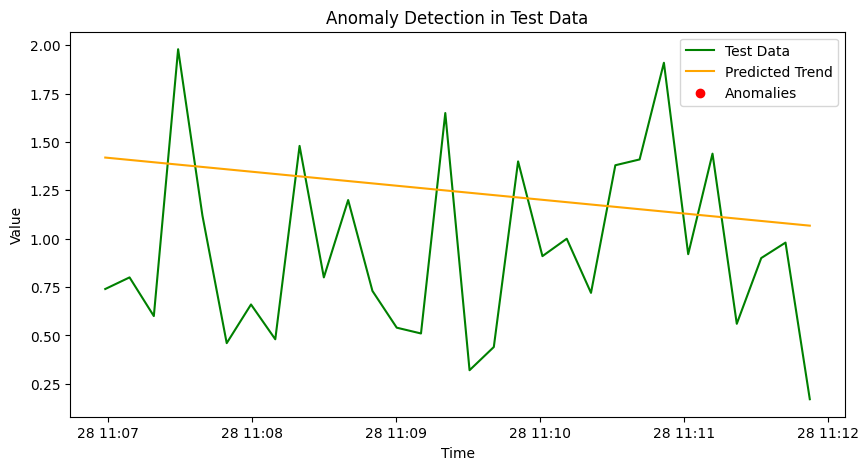

In [45]:
# Plot test anomaly detection, with predicted trend
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(test['ds'], test['yhat'], label='Predicted Trend', color='orange')
plt.scatter(test['ds'][test['anomaly']], test['y'][test['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Test Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

The model didn't detect any anomalies in the testing data, which is expected, as they are all relatively low, desired values. The trend was not predicted very precisely, but the average trend was predicted well, with a clear negative correlation.

Now, we can fit an ARIMA model to the data.

The parameters for ARIMA are Autoregressive Order (p), Differencing Order (d), and Moving Average (q). The best parameters were chosen after experimentation and simulation.

In [46]:
# Define the ARIMA model
model = ARIMA(train['y'], order=(5,1,0)) # (p, q d)
model_fit = model.fit()

In [47]:
# Predict on training data
train['yhat'] = model_fit.predict(start=0, end=len(train)-1, typ='levels')
train['residuals'] = train['y'] - train['yhat']

In [48]:
# Detect anomalies in training data using Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
train['anomaly'] = iso_forest.fit_predict(train[['residuals']])
train['anomaly'] = train['anomaly'] == -1  # Anomalies flagged as True

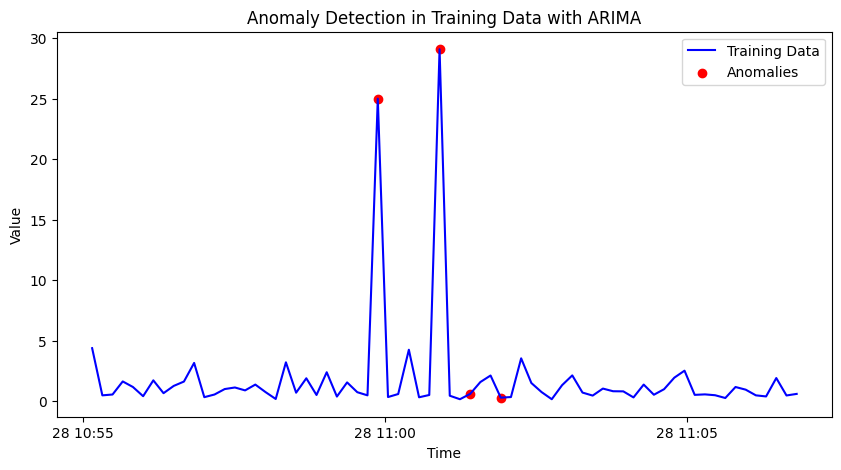

In [49]:
# Plot training anomalies
plt.figure(figsize=(10, 5))
plt.plot(train['ds'], train['y'], label='Training Data', color='blue')
plt.scatter(train['ds'][train['anomaly']], train['y'][train['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Training Data with ARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

We see that the model classified the obvious anomalies well, but also classified some unexpected anomalies. This may be due to the proximity of the data points near the anomalies that is factored in to the ARIMA algorithm

In [50]:
# Predict on test data
test['yhat'] = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels')
test['residuals'] = test['y'] - test['yhat']

In [51]:
# Detect anomalies in test data using Isolation Forest
test['anomaly'] = iso_forest.predict(test[['residuals']])
test['anomaly'] = test['anomaly'] == -1  # Anomalies flagged as True

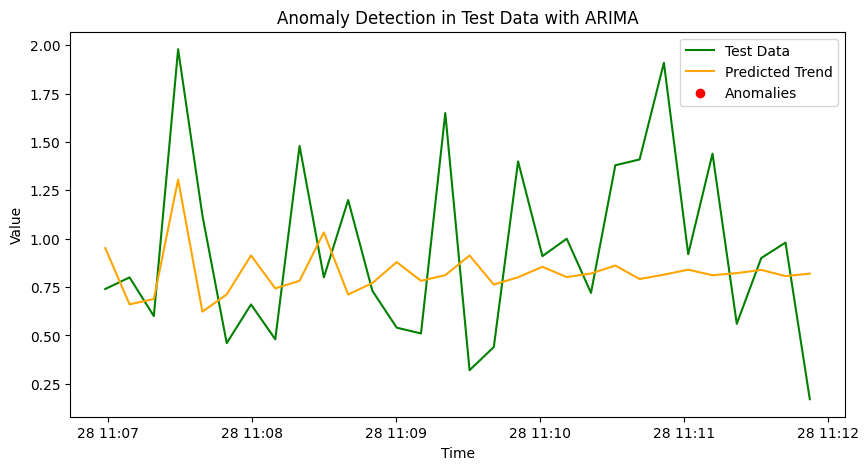

In [52]:
# Plot test anomalies
plt.figure(figsize=(10, 5))
plt.plot(test['ds'], test['y'], label='Test Data', color='green')
plt.plot(test['ds'], test['yhat'], label='Predicted Trend', color='orange')
plt.scatter(test['ds'][test['anomaly']], test['y'][test['anomaly']], color='red', label='Anomalies')
plt.title('Anomaly Detection in Test Data with ARIMA')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

The ARIMA also didn't detect any anomalies, which was the expected result, and the same as the Prophet model. However ARIMA did a better job at modeling and forecasting the trend. For Prophet, we saw that it predicted a linear trend, while for ARIMA, the predicted trend resembles the actual pattern of the predicted data.

## Conclusion

With more experimentation, a time series model like this could help detect issues with servers automatically in real time, allowing for efficient solution deployment.

